<a href="https://colab.research.google.com/github/alaeimo/NMA_DL_FER/blob/master/NMA_DL_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install torchinfo

In [34]:
#Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [5]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
set_seed(seed=2021)
device = set_device()


Random seed 2021 has been set.
GPU is enabled in this notebook.


Load and Prepare Dataset

In [7]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
emotions_inv = {v:k for k,v in emotions.items()}

In [8]:
class FER2013(Dataset):
    def __init__(self, csv_file:str, split:str='Training', transforms:transforms.Compose=None):
      """
      Arguments:
          csv_file (string): Path to the FER2013 icml_face_data.csv file with annotations.
          split = 'Training' for train , 'PublicTest' for validation, 'PrivateTest' for test
          transform (callable, optional): Optional transform to be applied on a sample.
      """
      self._main_df = pd.read_csv(csv_file)
      self.split = split
      self.transforms = transforms
      self._samples = self._load()

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        img, label = self._samples[idx]
        img = torch.as_tensor(img).float()
        if self.transforms:
            img = self.transforms(img)
        return img, label

    def _load(self):
      df = self._main_df
      df.columns = df.columns.str.replace(' ', '')
      df = df[df['Usage'] == self.split].copy()
      samples = []
      for index, row in df.iterrows():
          label = row['emotion']
          img_arr = row['pixels'].split(' ')
          img_arr = np.array(img_arr).astype(int)
          img_arr = img_arr.reshape(48,48)
          samples.append((img_arr, label))
      samples = np.array(samples, dtype=object)
      return samples

In [16]:
# Define the batch size
batch_size = 32
torchvision_transforms = True  # True/False if you want use torchvision augmentations
dataset_csv_file = "./drive/MyDrive/Colab Notebooks/datasets/fer2013/icml_face_data.csv"


# Define the transformations to apply
transforms_train = transforms.Compose([transforms.ToPILImage()])
if torchvision_transforms:
    transforms_train.transforms.extend([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=48, padding=4)])

transforms_train.transforms.extend([
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor()])

transforms_validation = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor()])

transforms_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])
# Create the dataset
train_dataset = FER2013(csv_file=dataset_csv_file, split='Training', transforms=transforms_train)
validation_dataset = FER2013(csv_file=dataset_csv_file, split='PublicTest', transforms=transforms_validation)
test_dataset = FER2013(csv_file=dataset_csv_file, split='PrivateTest', transforms=transforms_test)

# Create the data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
def show_dataloader_batch(dataloader):
  batch = next(iter(dataloader))
  # Extract the images and labels from the batch
  images, labels = batch
  # fig = plt.figure(figsize=(10, 10))
  for i in range(len(images)):
      ax = plt.subplot(4,len(images)//4 + 1, i+ 1)
      image = images[i]
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[labels[i].item()]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def show_dataset_batch(dataset, batch_size=20):
  for i in range(batch_size):
      image, label = dataset._samples[i]
      ax = plt.subplot(4, batch_size//4 + 1, i+ 1)
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[label]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

Train Dataset Samples


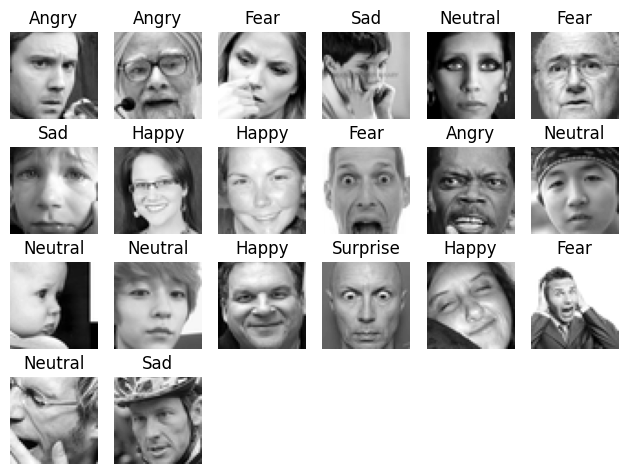

Transformed Train Dataset Samples


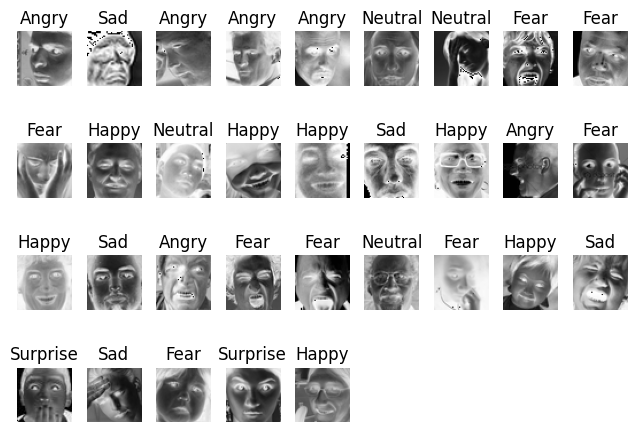

In [29]:
print("Train Dataset Samples")
show_dataset_batch(train_dataset)
print("Transformed Train Dataset Samples")
show_dataloader_batch(test_dataloader)

In [ ]:
#Preprocessing
# Face Alignment

Architecture 01: ResNet

In [43]:
# Define Resnet model and download pre-trained weights
resnet_model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze Layers
for param in resnet_model.parameters():
  param.requires_grad = False

# Display model summary
summary(resnet_model, input_size=(1, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 24, 24]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 24, 24]           (128)
├─ReLU: 1-3                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-4                         [1, 64, 12, 12]           --
├─Sequential: 1-5                        [1, 64, 12, 12]           --
│    └─BasicBlock: 2-1                   [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-1                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-4                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 12, 12]   

In [45]:
# Change the last Layer:
resnet_model.fc = torch.nn.Linear(in_features=512, out_features=7)
resnet_model.softmax = torch.nn.Softmax(dim=1)
# Display model summary
summary(resnet_model, input_size=(1, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 24, 24]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 24, 24]           (128)
├─ReLU: 1-3                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-4                         [1, 64, 12, 12]           --
├─Sequential: 1-5                        [1, 64, 12, 12]           --
│    └─BasicBlock: 2-1                   [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-1                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-4                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 12, 12]   

Set up training

In [48]:
base_learning_rate = 1e-5

In [50]:

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, out_model_name):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{out_model_name}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

 1- Set loss function and optimizer

In [49]:
# Optimizer and criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

 Training & Test functions

In [53]:
def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print(batch_idx, len(train_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, out_model_name, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(test_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(net, acc, epoch, out_model_name)
  return (test_loss/batch_idx, 100.*correct/total)

In [56]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
  print(batch_idx, (inputs.shape, targets.shape))

0 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
1 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
2 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
3 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
4 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
5 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
6 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
7 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
8 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
9 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
10 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
11 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
12 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
13 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
14 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
15 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
16 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
17 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
18 (torch.Size([32, 3, 48, 48]), torch.Size([32]))
19 (torch.Size([32, 3, 48, 48]), torch.Si

Train the model

In [59]:
start_epoch = 0
max_epochs = 1
use_cuda = True
out_model_name = "resnet18"
for epoch in range(start_epoch, max_epochs):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(resnet_model, epoch, use_cuda=use_cuda)
  # test_loss, test_acc = test(resnet_model, epoch, out_model_name, use_cuda=use_cuda)

  # print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
0 898 Loss: 2.031 | Acc: 18.750% (6/32)
500 898 Loss: 1.922 | Acc: 22.337% (3581/16032)
